In [65]:
import pickle as pkl
import yaml
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

In [43]:
global CFG
with open("../../config.yaml", "r") as ymlfile:
    CFG = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [44]:
rep_type = "ft"

In [45]:
xp_title = "disc_poly_b4_training_" + rep_type + "_avg_b4Training_1_1e-06"

In [46]:
xp_title
disc_poly_b4_training_ft_avg_b4Training_1_1e-06

SyntaxError: invalid token (<ipython-input-46-563d7740afe8>, line 2)

In [47]:
res_path = os.path.join(CFG["datadir"], "OUTPUTS_well_classified_" + xp_title)
with open(res_path, "rb") as f:
    b4_training = pkl.load(f)

In [22]:
b4_training["cie"].keys()

dict_keys([846743, 816326, 731356, 448170, 433780, 13352, 760174, 71371, 627185, 300964, 762510, 551992, 105169, 18098, 237469, 30173, 409723, 198835, 513306, 705476, 313233, 149685, 761660, 596816, 746166, 736518, 405897, 178186, 806409, 777996, 91791, 147345, 234513, 512295, 141879, 407865, 398395, 272187, 608959, 776137, 538315, 309452, 461006, 747472, 411753, 841194, 90475, 269544, 693832, 615624, 482003, 559123, 774869, 205539, 282500, 752567, 652035, 702610, 151965, 76344, 803832, 463451, 558340, 278426, 39120, 794507, 206210, 67108, 337636, 462631, 756842, 705195, 518062, 471251, 30138, 465186, 2514, 816915, 549564, 710407, 560298, 657463, 725214, 702502, 356559, 177203, 83190, 842878, 145567, 772963, 318486, 573376, 690350, 330256, 407953, 725877, 686236, 804671, 474192, 591733, 128579, 39816, 234769, 167966, 70052, 801337, 845892, 96839, 676686, 404950, 493278, 322790, 363752, 701547, 526580, 439288, 592636, 281968, 4816, 133810, 429687, 594143, 760902, 836309, 233591, 779313,

In [48]:
cie_dict = [i for i in b4_training["cie"]]
cie_outputs = np.array([b4_training["cie"][i][0] for i in cie_dict])
clus_dict = [i for i in b4_training["clus"]]
clus_outputs = np.array([b4_training["clus"][i][0] for i in clus_dict])
dpt_dict = [i for i in b4_training["dpt"]]
dpt_outputs = np.array([b4_training["dpt"][i][0] for i in dpt_dict])

In [49]:
b4_training["dpt"]

{127475: (array([24.514856, 24.090443, 23.943928, ..., 24.047323, 25.08767 ,
         23.411324], dtype=float32), 588),
 13658: (array([25.003208, 22.00551 , 22.42345 , ..., 23.171469, 25.287569,
         22.04536 ], dtype=float32), 1450),
 749642: (array([29.273018, 24.706589, 25.80358 , ..., 25.107977, 26.743868,
         24.877213], dtype=float32), 1637),
 408205: (array([25.283657, 23.462744, 23.88285 , ..., 23.293692, 23.415258,
         23.674135], dtype=float32), 1637),
 84174: (array([26.663963, 24.054176, 24.550577, ..., 23.956451, 24.179882,
         24.286575], dtype=float32), 1637),
 617170: (array([26.036879, 23.969421, 24.13932 , ..., 24.125227, 24.108059,
         24.421179], dtype=float32), 1637),
 271670: (array([25.208633, 23.341713, 23.592712, ..., 23.499725, 23.63495 ,
         23.679874], dtype=float32), 1637),
 226588: (array([26.163204, 23.682564, 24.909485, ..., 22.905039, 24.621851,
         26.76153 ], dtype=float32), 3078),
 318224: (array([27.656565, 25.8226

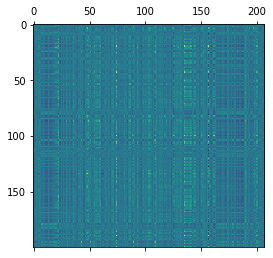

In [70]:
plt.matshow(shuffle(normalize(cie_outputs[:200])))


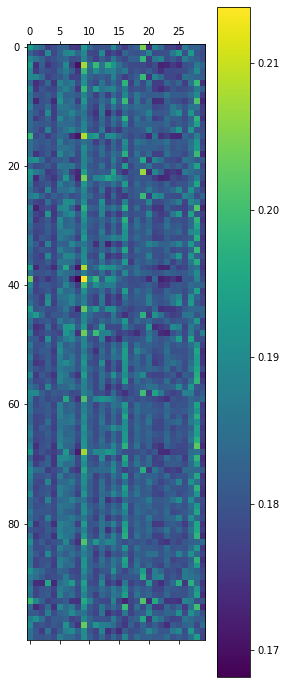

In [68]:
plt.matshow(shuffle(normalize(clus_outputs[:100])))
plt.colorbar()

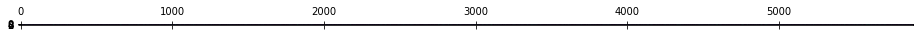

In [79]:
plt.matshow(normalize(dpt_outputs[:10,:]))



In [76]:
dpt_outputs[:][:1000].shape


(11, 5888)